In [10]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt

# 1. Load Genome Data
sequences = []
for seq_record in SeqIO.parse("Gene_Sequence.fasta", "fasta"):
    sequences.append(str(seq_record.seq))
    
if not sequences:
    raise ValueError("No sequences found in the FASTA file")

df = pd.DataFrame(sequences, columns=['sequence'])
print(f"Loaded {len(df)} sequences")

# 2. Generate dummy labels (replace with real labels in production)
df['label'] = np.random.randint(0, 2, len(df))

# 3. Preprocessing for LSTM
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(df['sequence'])
vocab_size = len(tokenizer.word_index) + 1

# Convert sequences to integers
X_seq = tokenizer.texts_to_sequences(df['sequence'])

# Determine padding length (use median length + 20% buffer)
seq_lengths = [len(seq) for seq in X_seq]
max_length = int(np.median(seq_lengths) * 1.2)
X_padded = pad_sequences(X_seq, maxlen=max_length, padding='post', truncating='post')

# 4. Handle different dataset sizes
if len(df) == 1:
    # Single sequence - just show tokenization
    print("\nSingle sequence analysis:")
    print(f"Original sequence: {df['sequence'][0][:50]}...")
    print(f"Tokenized sequence: {X_seq[0][:20]}...")
    print(f"Padded sequence: {X_padded[0][:20]}...")
    print(f"Vocabulary size: {vocab_size}")
    
elif len(df) == 2:
    # Two sequences - train on one, test on the other
    print("\nTraining with two sequences (train on first, test on second)")
    model = Sequential([
        Embedding(vocab_size, 16, input_length=max_length),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_padded[0:1], df['label'][0:1],
                       validation_data=(X_padded[1:2], df['label'][1:2]),
                       epochs=15, verbose=1)
    
    loss, accuracy = model.evaluate(X_padded[1:2], df['label'][1:2], verbose=0)
    print(f"\nTest Accuracy: {accuracy:.2f}")

else:
    # Normal train-test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_padded, df['label'], test_size=0.2, random_state=42)
    
    model = Sequential([
        Embedding(vocab_size, 64, input_length=max_length),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    print("\nTraining LSTM model...")
    history = model.fit(X_train, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_data=(X_test, y_test),
                       verbose=1)
    
    # Evaluation
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {accuracy:.2f}")
    
    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Show vocabulary mapping
print("\nNucleotide to integer mapping:")
print(tokenizer.word_index)

Loaded 1 sequences

Single sequence analysis:
Original sequence: CTCAAAAGTCTAGAGCCACCGTCCAGGGAGCAGGTAGCTGCTGGGCTCCG...
Tokenized sequence: [4, 3, 4, 1, 1, 1, 1, 2, 3, 4, 3, 1, 2, 1, 2, 4, 4, 1, 4, 4]...
Padded sequence: [4 3 4 1 1 1 1 2 3 4 3 1 2 1 2 4 4 1 4 4]...
Vocabulary size: 5

Nucleotide to integer mapping:
{'a': 1, 'g': 2, 't': 3, 'c': 4}


In [2]:
!pip install Bio

   ---------------------------------------- 0.0/281.0 kB ? eta -:--:--
   ---------------------------------------- 281.0/281.0 kB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.8 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.8 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.8 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.8 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.8 MB ? eta -:--:--
   -- ------------------------------------- 0.2/2.8 MB 692.9 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/2.8 MB 692.9 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/2.8 MB 692.9 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/2.8 MB 692.9 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/2.8 MB 692.9 kB/s eta 0:00:04
   -- ------------------------------------- 0

In [3]:
pip list

Package                           VersionNote: you may need to restart the kernel to use updated packages.

--------------------------------- ------------
absl-py                           2.2.2
aiobotocore                       2.7.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.1.4
anaconda-navigator                2.5.2
anaconda-project                  0.11.1
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy                           5.3.4

Original sequence length: 19070
Created 380 windows of size 100


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

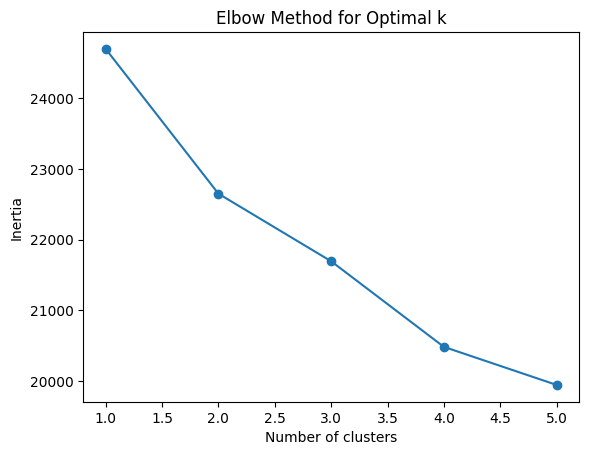


Classification Accuracy: 0.71


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


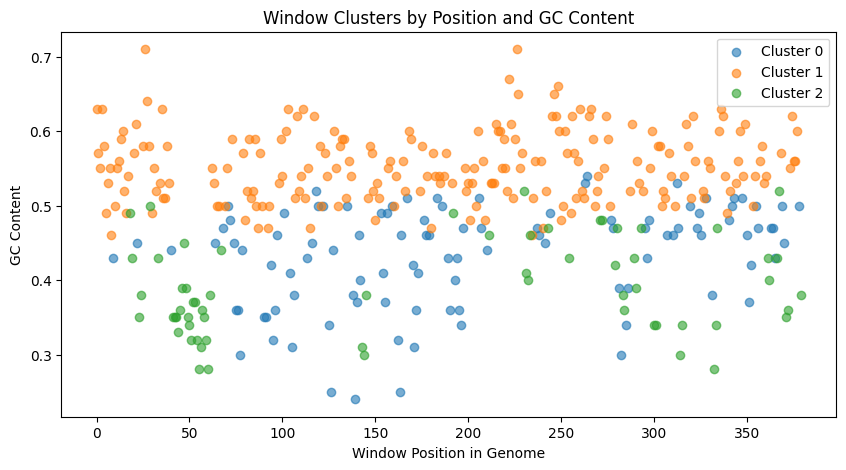

In [11]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Load and preprocess single sequence
record = next(SeqIO.parse("Gene_Sequence.fasta", "fasta"))
sequence = str(record.seq)
seq_length = len(sequence)

print(f"Original sequence length: {seq_length}")

# 2. Split into overlapping windows
window_size = 100  # Adjust based on your sequence
step_size = 50     # Overlap between windows
windows = [sequence[i:i+window_size] 
          for i in range(0, seq_length-window_size, step_size)]

print(f"Created {len(windows)} windows of size {window_size}")

# 3. Feature extraction (k-mer frequencies)
def get_kmer_freq(seq, k=3):
    from collections import defaultdict
    freq = defaultdict(int)
    for i in range(len(seq)-k+1):
        kmer = seq[i:i+k]
        freq[kmer] += 1
    total = sum(freq.values())
    return {k:v/total for k,v in freq.items()}

# Create feature matrix
k = 3
all_kmers = set()
for window in windows:
    kmers = get_kmer_freq(window, k)
    all_kmers.update(kmers.keys())

# Convert to DataFrame
features = []
for window in windows:
    freqs = get_kmer_freq(window, k)
    features.append([freqs.get(kmer, 0) for kmer in sorted(all_kmers)])

df = pd.DataFrame(features, columns=sorted(all_kmers))
df['window'] = windows
df['gc_content'] = df['window'].apply(
    lambda x: (x.count('G') + x.count('C'))/window_size)

# 4. Clustering (K-Means on k-mer features)
X = df.drop('window', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal clusters (elbow method)
inertias = []
for n in range(1, 6):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,6), inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Apply clustering with selected k
optimal_k = 3  # Change based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 5. Classification (create synthetic labels)
# Generate position-based labels (example: first half vs second half)
df['label'] = np.where(df.index < len(df)/2, 0, 1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df['label'], test_size=0.2, random_state=42)

# Train classifier
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

# Evaluate
accuracy = clf.score(X_test, y_test)
print(f"\nClassification Accuracy: {accuracy:.2f}")

# Visualize clusters by GC content and length
plt.figure(figsize=(10,5))
for cluster in sorted(df['cluster'].unique()):
    subset = df[df['cluster'] == cluster]
    plt.scatter(subset.index, subset['gc_content'], 
               label=f'Cluster {cluster}', alpha=0.6)
plt.title('Window Clusters by Position and GC Content')
plt.xlabel('Window Position in Genome')
plt.ylabel('GC Content')
plt.legend()
plt.show()

Epoch 1/15
10/10 [==============================] - 4s 111ms/step - loss: 0.6932 - accuracy: 0.5066 - val_loss: 0.6913 - val_accuracy: 0.6316
Epoch 2/15
10/10 [==============================] - 0s 41ms/step - loss: 0.6942 - accuracy: 0.5066 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 3/15
10/10 [==============================] - 0s 40ms/step - loss: 0.6893 - accuracy: 0.5428 - val_loss: 0.6845 - val_accuracy: 0.5789
Epoch 4/15
10/10 [==============================] - 0s 40ms/step - loss: 0.6837 - accuracy: 0.5033 - val_loss: 0.6598 - val_accuracy: 0.5789
Epoch 5/15
10/10 [==============================] - 0s 40ms/step - loss: 0.6671 - accuracy: 0.6053 - val_loss: 0.6563 - val_accuracy: 0.6447
Epoch 6/15
10/10 [==============================] - 0s 40ms/step - loss: 0.6662 - accuracy: 0.6217 - val_loss: 0.6564 - val_accuracy: 0.6184
Epoch 7/15
10/10 [==============================] - 0s 40ms/step - loss: 0.6609 - accuracy: 0.6086 - val_loss: 0.6584 - val_accuracy: 0.5658
Epoch 8/15
1

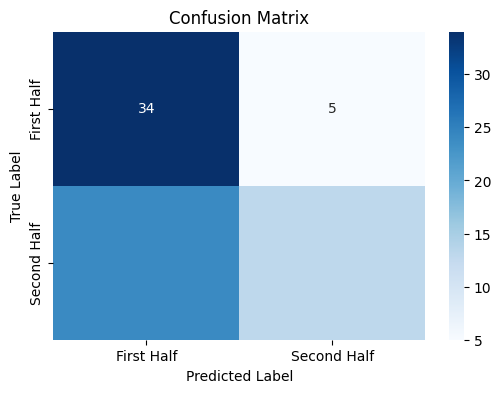

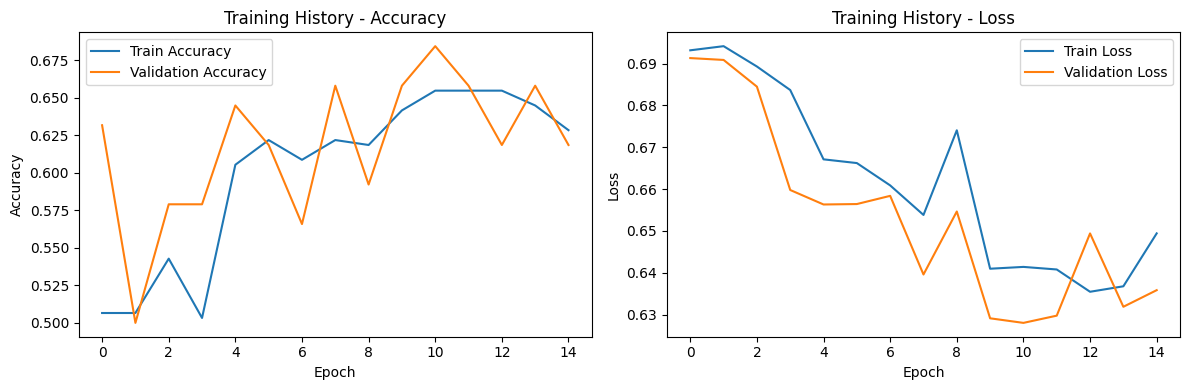

12/12 [==============================] - 0s 12ms/step


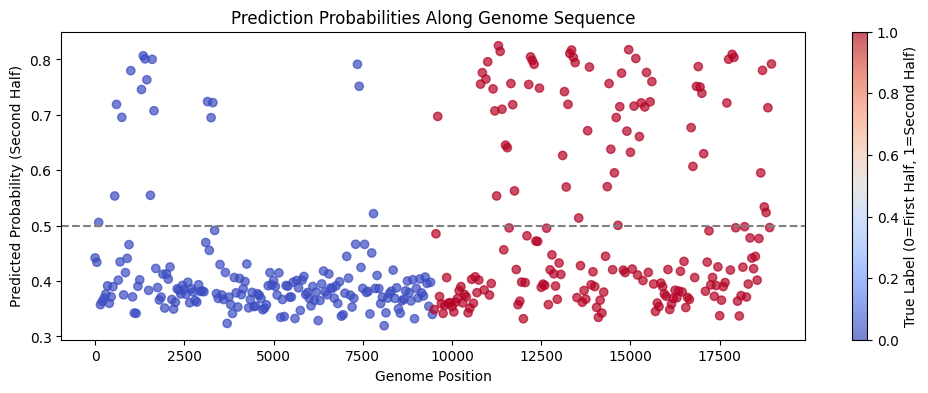

In [12]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and preprocess single sequence
record = next(SeqIO.parse("Gene_Sequence.fasta", "fasta"))
sequence = str(record.seq)
seq_length = len(sequence)

# 2. Split into windows and create synthetic labels
window_size = 100
step_size = 50
windows = [sequence[i:i+window_size] 
          for i in range(0, seq_length-window_size, step_size)]

# Create position-based labels (first half = 0, second half = 1)
labels = np.where(np.arange(len(windows)) < len(windows)/2, 0, 1)

# 3. DNA sequence tokenization
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(windows)
vocab_size = len(tokenizer.word_index) + 1

# Convert to integer sequences
X_seq = tokenizer.texts_to_sequences(windows)
X_padded = pad_sequences(X_seq, maxlen=window_size, padding='post')

# 4. Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42)

# 6. Build LSTM model
model = Sequential([
    Embedding(vocab_size, 32, input_length=window_size),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 7. Train model
history = model.fit(X_train, y_train,
                   epochs=15,
                   batch_size=32,
                   validation_data=(X_test, y_test),
                   verbose=1)

# 8. Evaluation
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['First Half', 'Second Half']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['First Half', 'Second Half'],
            yticklabels=['First Half', 'Second Half'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Training history plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# 9. Visualize predictions along sequence
windows_df = pd.DataFrame({
    'position': np.arange(len(windows)) * step_size,
    'true_label': y,
    'pred_prob': model.predict(X_padded).flatten()
})

plt.figure(figsize=(12,4))
plt.scatter(windows_df['position'], windows_df['pred_prob'], 
           c=windows_df['true_label'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='True Label (0=First Half, 1=Second Half)')
plt.title('Prediction Probabilities Along Genome Sequence')
plt.xlabel('Genome Position')
plt.ylabel('Predicted Probability (Second Half)')
plt.axhline(0.5, color='gray', linestyle='--')
plt.show()